# Imports and folder paths

In [72]:
#imports, data folders and necessary requirements
PATH_FOLDER = "MovieSummaries/"
PATH_FOLDER1 = "IMDb data files/" 
PATH_FOLDER2 = "The Movies Dataset/"

! pip install spacy
!pip install -U textblob
!pip install --user -U nltk
!python -m spacy download en_core_web_sm

import os
import json
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import nltk
import spacy
import string
from textblob import TextBlob
from collections import Counter
from nltk.sentiment.util import *
from nltk.corpus import stopwords
from sklearn import preprocessing
from nltk.corpus import subjectivity
from nltk.tokenize import word_tokenize
from spacy.lang.en.examples import sentences
from nltk.sentiment import SentimentAnalyzer
from nltk.classify import NaiveBayesClassifier
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))
stop_words.add(string.punctuation)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package punkt to /Users/ahmedaziz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ahmedaziz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. CMU Movie Summary Corpus Datasets

# TRAIN DATA

## 1) Character Metadata

Metadata for 450,669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase.  

Tab-separated; columns:
1. Wikipedia movie ID 
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID

---



In [26]:
character_file_name = os.path.join(PATH_FOLDER, 'character.metadata.tsv')
names_1 = ["Wikipedia movie ID",
            "Freebase movie ID", 
            "Movie release date", 
            "Character name", 
            "Actor date of birth", 
            "Actor gender", 
            "Actor height (in meters)", 
            "Actor ethnicity (Freebase ID)",
            "Actor name", 
            "Actor age at movie release", 
            "Freebase character/actor map ID", 
            "Freebase character ID",
            "Freebase actor ID"]

character_metadata = pd.read_csv(character_file_name,  sep="\t", names= names_1)
character_metadata.sample(3)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
254574,2238130,/m/06y9rw,1946-09-06,NaN,1890-05-23,M,1.83,NaN,Herbert Marshall,NaN,/m/0jwqxd,NaN,/m/04xxwy
373080,7420852,/m/0kv717,1996-01-29,NaN,1914-09-10,M,NaN,NaN,Robert Wise,81.0,/m/0h2pbrb,NaN,/m/0hsmh
431131,26671984,/m/05pdh56,2009,NaN,1968-06-14,M,1.77,/m/03yk6g,Faizon Love,40.0,/m/0cs7562,NaN,/m/06zn34


## 2) Movie Metadata

Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase. 

Tab-separated; columns:
1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)





In [109]:
movie_file_name = os.path.join(PATH_FOLDER, 'movie.metadata.tsv')
names_2 = ["Movie ID", 
            "Freebase movie ID", 
            "Movie name", 
            "Movie release date", 
            "Movie box office revenue", 
            "Movie runtime", 
            "Movie languages (Freebase ID:name tuples)",
            "Movie countries (Freebase ID:name tuples)", 
            "Movie genres (Freebase ID:name tuples)"]

movie_metadata = pd.read_csv(movie_file_name,  sep="\t", names = names_2)

# Select the year from the release data feature
movie_metadata['year'] = movie_metadata['Movie release date'].apply(lambda x: int(str(x)[:4]) if type(x) == str and len(str(x)) >= 4 else x)
movie_metadata.sample(3) 

,Movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),year
59427,7564146,/m/0kvbf7,Black Sheep,2006,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0chghy"": ""Australia"", ""/m/0ctw_b"": ""New Z...","{""/m/06vxwl5"": ""Natural horror films"", ""/m/03n...",2006.0
19296,2861237,/m/087gfp,Last Dance,1996-05-03,5939449.0,103.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",1996.0
32256,33430032,/m/0h96h96,Njeriu prej Dheut,1984-11-12,NaN,102.0,{},{},"{""/m/01jfsb"": ""Thriller"", ""/m/07s9rl0"": ""Drama""}",1984.0


## 3) Plot Summaries

Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia. Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.

In [28]:
summary_file_name = os.path.join(PATH_FOLDER, 'plot_summaries.txt')
summary_metadata = pd.read_csv(summary_file_name,  sep="\t", names= ["Movie ID", "Movie Summary"])

summary_metadata["Movie Summary"] = summary_metadata["Movie Summary"].astype("string")
summary_metadata.sample(3)

,Movie ID,Movie Summary
35276,27953778,"In Hong Kong, Cheng Lai-sheung works two jobs..."
8310,29328011,Lawyer Michael Grey is summoned to an isolate...
42275,12118772,Kidstuff has been asked by the police to inve...


## 4) Stanford CoreNLP Plot Summaries

The plot summaries, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Each filename begins with the Wikipedia movie ID (which indexes into movie.metadata.tsv).

In [110]:
# to be added

# TEST DATA

## 1) Tvtropes clusters

72 character types drawn from tvtropes.com, along with 501 instances of those types. The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.


In [30]:
tvtropes_file_name = os.path.join(PATH_FOLDER, 'tvtropes.clusters.txt')
tvtropes_metadata = pd.read_csv(tvtropes_file_name, sep="\t", names = ['character', 'data'])

# Convert the 'data' column to strings
tvtropes_metadata['data'] = tvtropes_metadata['data'].apply(lambda x: str(x))

# Extract and convert the JSON data to separate columns
tvtropes_metadata = pd.DataFrame([(character_type, json.loads(data)) for character_type, data
               in zip(tvtropes_metadata['character'], tvtropes_metadata['data'])])

# Redefine columns lost from the previous operation
tvtropes_metadata.columns = ['character', 'data']

# Expand the 'data' column into separate columns
tvtropes_metadata = pd.concat([tvtropes_metadata, tvtropes_metadata['data'].apply(pd.Series)], axis=1)

# Drop the original 'data' column
tvtropes_metadata.drop('data', axis=1, inplace=True)

tvtropes_metadata.columns = [[ 'Character role',
                               'Character name',
                               'Movie name',
                               'Freebase character/actor map ID', 
                               'Actor name' ]]

tvtropes_metadata.sample(3)

,Character role,Character name,Movie name,Freebase character/actor map ID,Actor name
442,stoner,Thadeous,Your Highness,/m/07zm_ym,Danny McBride
20,big_man_on_campus,Woody Deane,It's a Boy Girl Thing,/m/02vc983,Kevin Zegers
71,byronic_hero,Britt Reid,The Green Hornet,/m/0h5m_9x,Seth Rogen


## 2) Name clusters

970 unique character names used in at least two different movies, along with 2,666 instances of those types. The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.


In [31]:
name_file_name = os.path.join(PATH_FOLDER, 'name.clusters.txt')
name_metadata = pd.read_csv(name_file_name,  sep="\t", names= ["character name", "Freebase character/actor map ID"])
name_metadata.sample(3)

,character name,Freebase character/actor map ID
1501,Mycroft Holmes,/m/0gk8kt8
316,Sophie Piper,/m/04djh67
1079,Miss Finster,/m/0kxcszg


# ------------------------------------------------------------

# 2. IMDb Non-Commercial Datasets

## 1) title-basics file - title.basics.tsv.gz
contains:  
tconst (string) - alphanumeric unique identifier of the title  
titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)  
primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release  
originalTitle (string) - original title, in the original language  
isAdult (boolean) - 0: non-adult title; 1: adult title  
startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year 
endYear (YYYY) – TV Series end year. ‘\N’ for all other title types  
runtimeMinutes – primary runtime of the title, in minutes  
genres (string array) – includes up to three genres associated with the title

In [32]:
title_basic_path = os.path.join(PATH_FOLDER1, 'data-4.tsv')
title_basic_cols = ["tconst", 
            "titleType",
            "primaryTitle",
            "originalTitle",
            "isAdult",
            "startYear",
            "end year",
            "runtimeMinutes",
            "genres"]

imdb_title_basic_metadata = pd.read_csv(title_basic_path,  sep="\t", names= title_basic_cols)
imdb_title_basic_metadata.dropna(inplace=True)
print(imdb_title_basic_metadata.shape)
imdb_title_basic_metadata.sample(5)

/var/folders/rm/rt_43b293mv9fnxz5pb_wdd00000gn/T/ipykernel_4510/934579659.py:12: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_title_basic_metadata = pd.read_csv(title_basic_path,  sep="\t", names= title_basic_cols)


(10316916, 9)


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,end year,runtimeMinutes,genres
2687450,tt13137860,short,Galaxy of Fear: A Star Wars Fan Film,Galaxy of Fear: A Star Wars Fan Film,0,2021,\N,4,"Action,Adventure,Fantasy"
4624539,tt17373364,short,Wild Child,Wild Child,0,2021,\N,\N,"Documentary,Short"
6069840,tt2421668,tvEpisode,March,March,0,2012,\N,7,Drama
1528050,tt11008180,tvEpisode,Episode #1.172,Episode #1.172,0,2018,\N,\N,Drama
7919161,tt4608826,short,0930 Hours,0930 Hours,0,2015,\N,6,"Drama,Short"


## 2) title ratings file - title.ratings.tsv.gz
contains:    
tconst (string) - alphanumeric unique identifier of the title    
averageRating – weighted average of all the individual user ratings  
numVotes - number of votes the title has received

In [33]:
ratings_path = os.path.join(PATH_FOLDER1, 'data.tsv')
ratings_cols = ["tconst", 
            "averageRating",
            "numVotes"]

imdb_ratings_metadata = pd.read_csv(ratings_path,  sep="\t", names= ratings_cols)
imdb_ratings_metadata.dropna(inplace=True)
print(imdb_ratings_metadata.shape)
imdb_ratings_metadata.sample(5)

/var/folders/rm/rt_43b293mv9fnxz5pb_wdd00000gn/T/ipykernel_4510/2467255112.py:6: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_ratings_metadata = pd.read_csv(ratings_path,  sep="\t", names= ratings_cols)


(1369211, 3)


,tconst,averageRating,numVotes
764565,tt1650707,7.3,17
50086,tt0072985,5.3,12
367918,tt0731971,8.0,341
397012,tt0810767,8.6,23
20076,tt0037978,4.7,16


# ------------------------------------------------------------

# 3. The Movie Dataset from Kaggle

## 1) movies_metadata.csv: 
The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.

In [34]:
tmd_movies_path = os.path.join(PATH_FOLDER2, 'movies_metadata.csv')
tmd_movies_cols = ["adult", 
            "belongs_to_collection",
            "budget",
			"genres",
			"homepage",
			"id",
			"imdb_id",
			"original_language",
			"original_title",
			"overview",
			"popularity",
			"poster_path",
			"production_companies",
			"production_countries",
			"release_date",
			"revenue",
			"runtime",
			"spoken_languages",
			"status",
			"tagline",
			"title",
			"video",
			"vote_average",
			"vote_count"]

used_columns = ["id","budget",
			"imdb_id",
			"popularity",
			"production_companies",
			"production_countries",
			"vote_average",
			"vote_count"]

tmd_movies_metadata = pd.read_csv(tmd_movies_path, low_memory=False, encoding='ISO-8859-1', usecols=used_columns)
tmd_movies_metadata.dropna(inplace=True)
print(tmd_movies_metadata.shape)
tmd_movies_metadata.dropna(inplace=True)
tmd_movies_metadata.sample(5)

(45443, 8)


,budget,id,imdb_id,popularity,production_companies,production_countries,vote_average,vote_count
22267,0,77161,tt0162854,0.106259,[],[],6.3,3.0
28527,0,228203,tt2097298,6.894606,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",7.4,216.0
10356,0,30230,tt0024183,1.106024,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...",5.2,6.0
26262,0,105576,tt0067949,1.364958,[],"[{'iso_3166_1': 'FR', 'name': 'France'}]",4.6,6.0
10287,0,46825,tt0424237,1.874371,"[{'name': 'Pyramide Productions', 'id': 186}, ...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",7.1,15.0


# ----------------------------------------------------------

# FUNCTIONS (WILL BE MOVED TO HELPER CLASS LATER)

In [35]:
#function used to tokenize into dataframe columns into single words
def tokenize(column):
    """Tokenizes a Pandas dataframe column and returns a list of tokens.

    Args:
        column: Pandas dataframe column.

    Returns:
        tokens (list): Tokenized list.
    """

    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()] 

In [36]:
#Function to split data between train and test
def split_set(data_to_split, ratio=0.8):
    """split data between train and test.

    Args:
        data_to_split: Pandas dataframe.
        ratio: ratio train/test data (default value: 0.8)

    Returns:
        train and test dataframes.
    """
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask].reset_index(drop=True), data_to_split[~mask].reset_index(drop=True)]

In [37]:
def outliers_removal(
    x_train_normalized, y_train, threshold=3, max_false_percentage=0.1
):
    """
    Remove outliers from the training data based on z-scores and a false percentage threshold.

    Parameters:
    - x_train_normalized (numpy.ndarray): Normalized training feature matrix.
    - y_train (numpy.ndarray): Training target labels.
    - threshold (float): Z-score threshold for defining outliers (default is 3).
    - max_false_percentage (float): Maximum acceptable percentage of False values in a row (default is 0.3).

    Returns:
    - x_train_cleaned (numpy.ndarray): Training feature matrix with outliers removed.
    - y_train_cleaned (numpy.ndarray): Training target labels with corresponding outliers removed.
    """

    z_scores = np.abs(x_train_normalized)

    # Create a mask of non-outliers
    outlier_mask = z_scores < threshold

    # Calculate the percentage of False values in each row of the mask
    false_percentages = 1 - np.mean(outlier_mask, axis=1)

    # Check if the false percentage is less than the threshold (10%)
    non_outlier_rows = false_percentages < max_false_percentage

    return x_train_normalized[non_outlier_rows], y_train[non_outlier_rows]

In [75]:
def plot_residuals(features_to_plot, test_features,test_label, prediction):
    num_features = len(features_to_plot)
    num_rows = (num_features // 3) + (1 if num_features % 3 != 0 else 0)

    fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5), sharey=True)

    for i, feature in enumerate(features_to_plot):
        row_index = i // 3
        col_index = i % 3

        residuals = test_label - prediction

        if num_rows > 1:
            ax = axes[row_index, col_index]
        else:
            ax = axes[col_index]

        ax.bar(test_features[feature], residuals, color='green', label='Residuals')
        ax.set_xlabel(feature)
        ax.set_ylabel('Difference (True - Predicted)')
        ax.axhline(0, color='black', linestyle='--', linewidth=1)
        ax.set_title(f'Residuals for {feature}')
        ax.legend()

    plt.tight_layout()
    plt.show()

In [47]:
def standerdize(train_features, test_features):

    #standerdize train and test features
    means = train_features.mean()
    stddevs = train_features.std()

    train_features_std = pd.DataFrame()
    for c in train_features.columns:
        train_features_std[c] = (train_features[c]-means[c])/stddevs[c]

    # Use the mean and stddev of the training set
    test_features_std = pd.DataFrame()
    for c in test_features.columns:
        test_features_std[c] = (test_features[c]-means[c])/stddevs[c]

    return train_features_std, test_features_std

# DATA ANALYSIS

### we perform a linear regression model on our movie metadata and character metadata from the CMU Movie Summary Corpus Datasets selecting only "actor gender", "movie runtime", "actor age at movie release" features

In [45]:
# Merge the movie and character dataframes based on the "Freebase movie ID"
movie_character_metadata = pd.merge(movie_metadata, character_metadata, on="Freebase movie ID", how='outer')

# Drop NAN values from the merged dataframe
movie_character_metadata.dropna(inplace=True)

movie_character_metadata.sample(3)

,Wikipedia movie ID_x,Freebase movie ID,Movie name,Movie release date_x,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),year,...,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
386354,171026,/m/016y_f,Cape Fear,1991-11-13,182291969.0,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",1991.0,...,Lee Heller,1916-04-05,M,1.905,/m/07bch9,Gregory Peck,75.0,/m/0bhhp89,/m/0bhhp8d,/m/0k9j_
148468,518018,/m/02krdz,Freddy Got Fingered,2001-04-18,14333252.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/01hwc6"": ""Absurd...",2001.0,...,Davidson's Receptionist,1975-02-22,F,1.630,/m/033tf_,Drew Barrymore,26.0,/m/098cl38,/m/0gxp9mc,/m/026c1
206163,3518352,/m/09h_3d,The Bachelor and the Bobby-Soxer,1947-09-01,5550000.0,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/06qm3"": ""S...",1947.0,...,Susan,1928-04-23,F,1.570,/m/02w7gg,Shirley Temple,19.0,/m/0k4cq8,/m/0gy76r4,/m/03d9v8


**Remark:** The original distribution of movie box office revenue exhibits a heavy-tailed pattern, with a few movies achieving extremely high revenues. By applying a logarithmic transformation, we approximate a more normal distribution, making the data more amenable to statistical analyses that assume normality.

Text(0, 0.5, 'Frequency')

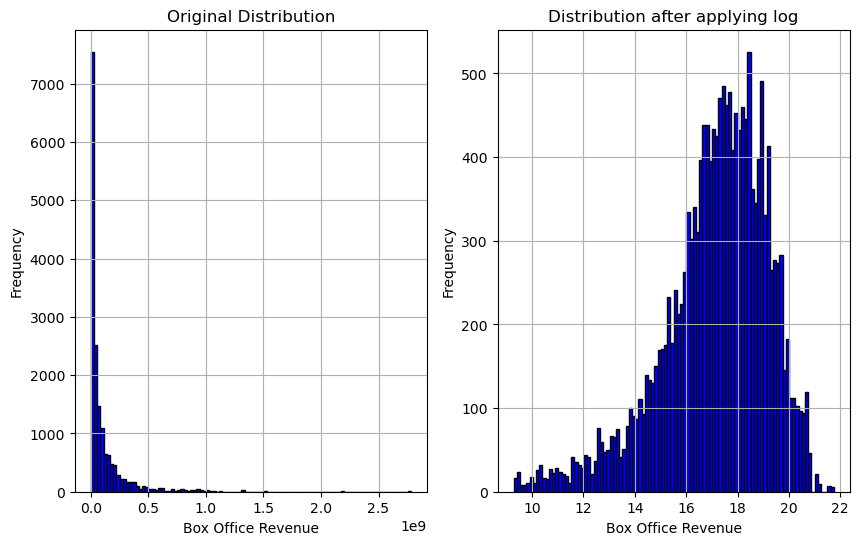

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Plotting the original distribution and the distribution after applying log function on the revenue feature
movie_character_metadata_train["Movie box office revenue"].hist(ax=axs[0], bins=100, color='blue', edgecolor='black')
movie_character_metadata_train["Movie box office revenue"].apply(lambda x: np.log(x)).hist(ax=axs[1], bins=100, color='blue', edgecolor='black')
axs[0].set_title('Original Distribution')
axs[0].set_xlabel('Box Office Revenue')
axs[0].set_ylabel('Frequency')
axs[1].set_title('Distribution after applying log')
axs[1].set_xlabel('Box Office Revenue')
axs[1].set_ylabel('Frequency')

In [60]:
le = preprocessing.LabelEncoder()

# Encode gender feature from the merged dataframe
le.fit(movie_character_metadata['Actor gender'])
movie_character_metadata['Actor gender']= le.transform(movie_character_metadata['Actor gender'])

# Dataframe containing only the used input features and the output feature
movie_character_metadata_reduced_df = movie_character_metadata[['Movie runtime', 'Actor gender', 'Actor age at movie release', 'Movie box office revenue']]

[movie_character_metadata_train, movie_character_metadata_test] = split_set(movie_character_metadata_reduced_df)

# Divide the train and test dataframes according to input and output features
movie_character_metadata_train_label = movie_character_metadata_train["Movie box office revenue"].apply(lambda x: np.log(x))
movie_character_metadata_train_features = movie_character_metadata_train.drop("Movie box office revenue", axis=1)
movie_character_metadata_test_label = movie_character_metadata_test["Movie box office revenue"].apply(lambda x: np.log(x))
movie_character_metadata_test_features = movie_character_metadata_test.drop("Movie box office revenue", axis=1)

In [85]:
#standerdize train and test features
movie_character_metadata_train_features_std, movie_character_metadata_test_features_std = \
    standerdize(movie_character_metadata_train_features, movie_character_metadata_test_features)

#train a linear regression model on the train set
model = LinearRegression()
model.fit(movie_character_metadata_train_features_std,movie_character_metadata_train_label)

LinearRegression()

In [87]:
#prediction on test features
movie_character_metadata_prediction = model.predict(movie_character_metadata_test_features_std)

#Evaluate the model
mse = mean_squared_error(movie_character_metadata_test_label, movie_character_metadata_prediction)
print("Mean Squared Error:", mse)
print(movie_character_metadata_prediction.shape)
print(movie_character_metadata_test_label.shape)

Mean Squared Error: 4.031237536780052
(4336,)
(4336,)


In [88]:
# Get the coefficients of the model
coefficients = model.coef_

# Get the intercept of the model
intercept = model.intercept_

# Print or use the coefficients and intercept as needed
print("Coefficients of the initial basic model:", coefficients)
print("Intercept of the initial basic model:", intercept)

Coefficients of the initial basic model: [0.37603442 0.10390745 0.122332  ]
Intercept of the initial basic model: 17.115148025818762


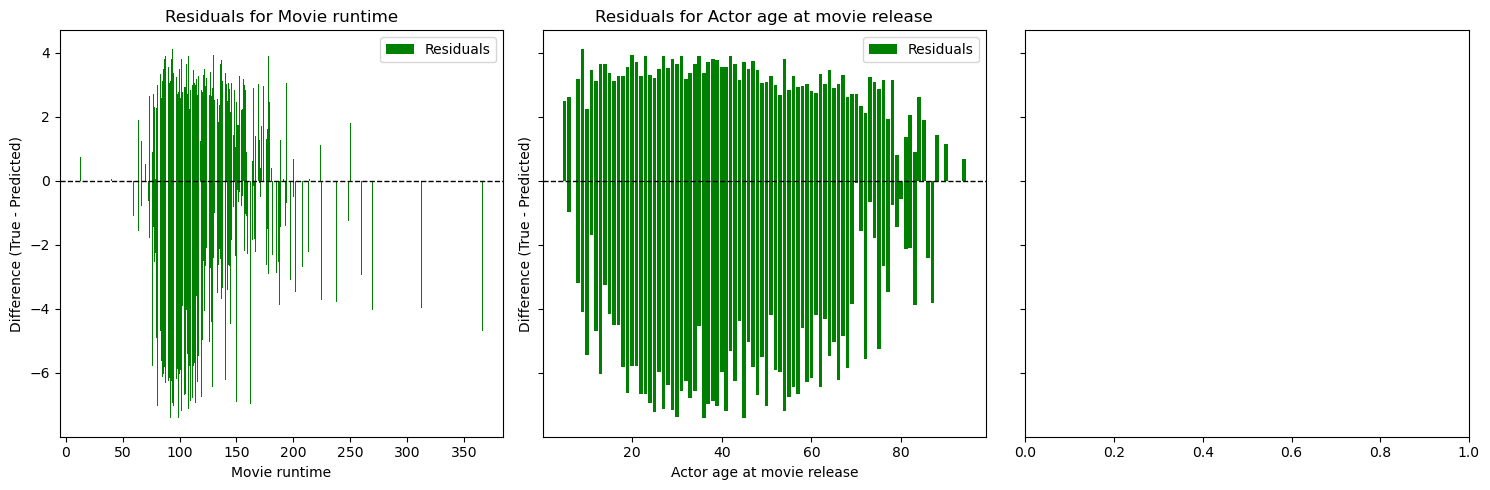

In [90]:
# Plot the difference between the true and predicted output with respect to each continuous feature
plot_residuals(['Movie runtime', 'Actor age at movie release'], 
movie_character_metadata_test_features, movie_character_metadata_test_label, movie_character_metadata_prediction)

# comment this

### Using the plot_summary dataset, we perform a sentiment analysis over each movie summary extracting positive and negative words and performing a linear regression model using the positive and negative words featurs as well as the movie runtime having as output the box office revenues

In [116]:
#create a copy for the summary metadata
summary_metadata_copy = summary_metadata.copy()
print(f"The shape of the summary metadata before removing duplicates is : {summary_metadata_copy.shape}")

#Remove duplicate values
summary_metadata_copy = summary_metadata_copy.drop_duplicates("Movie Summary")
print(f"The shape of the summary metadata after removing duplicates is : {summary_metadata_copy.shape}")

The shape of the summary metadata before removing duplicates is : (42303, 2)
The shape of the summary metadata after removing duplicates is : (42295, 2)


In [98]:
#add a column containing tokenized summaries into words
summary_metadata_copy.loc[:, 'tokenized_summary'] = summary_metadata_copy.apply(lambda x: tokenize(x['Movie Summary']), axis=1)

display(summary_metadata_copy)

,Movie ID,Movie Summary,tokenized_summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Shlykov, a, taxi, driver, and, Lyosha, a, sax..."
1,31186339,The nation of Panem consists of a wealthy Capi...,"[The, nation, of, Panem, consists, of, a, weal..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"[Poovalli, Induchoodan, is, sentenced, for, si..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[The, Lemon, Drop, Kid, a, New, York, City, sw..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,"[Adventist, Church, pastor, Michael, Chamberla..."
...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...","[The, story, is, about, Reema, a, young, Musli..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...","[In, Hollywood, director, Leo, Andreyev, looks..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,"[American, Luthier, focuses, on, Randy, Parson..."
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...","[Abdur, Rehman, Khan, a, dry, fruit, seller, f..."


In [101]:
#Filter the column containing tokenized text by deleting all stopwords
summary_metadata_copy.loc[:, 'filtered_Tokens'] = summary_metadata_copy['tokenized_summary'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])

display(summary_metadata_copy)

,Movie ID,Movie Summary,tokenized_summary,filtered_Tokens
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Shlykov, a, taxi, driver, and, Lyosha, a, sax...","[Shlykov, taxi, driver, Lyosha, saxophonist, d..."
1,31186339,The nation of Panem consists of a wealthy Capi...,"[The, nation, of, Panem, consists, of, a, weal...","[nation, Panem, consists, wealthy, Capitol, tw..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"[Poovalli, Induchoodan, is, sentenced, for, si...","[Poovalli, Induchoodan, sentenced, six, years,..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[The, Lemon, Drop, Kid, a, New, York, City, sw...","[Lemon, Drop, Kid, New, York, City, swindler, ..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,"[Adventist, Church, pastor, Michael, Chamberla...","[Adventist, Church, pastor, Michael, Chamberla..."
...,...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...","[The, story, is, about, Reema, a, young, Musli...","[story, Reema, young, Muslim, schoolgirl, Mala..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...","[In, Hollywood, director, Leo, Andreyev, looks...","[Hollywood, director, Leo, Andreyev, looks, ph..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,"[American, Luthier, focuses, on, Randy, Parson...","[American, Luthier, focuses, Randy, Parsons, t..."
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...","[Abdur, Rehman, Khan, a, dry, fruit, seller, f...","[Abdur, Rehman, Khan, dry, fruit, seller, Afgh..."


In [102]:
#Initialize an empty list to store percentage of positive, negative and neutral words in each row of the 'filtered_Tokens' column 
positive_scores = []
negative_scores = []
neutral_scores = []
sentiment_scores = []

#Perform sentiment analysis on each word
for liss in summary_metadata_copy['filtered_Tokens'] :
  
  # initialize all the counter to 0
  nbr_words_pos = 0
  nbr_words_neg = 0
  nbr_words_neu = 0
  nbr_words = 0

  for word in liss:
    nbr_words+= 1
    blob = TextBlob(word)
    #perform sentiment polarities of the word
    if (blob.sentiment.polarity > 0):
        nbr_words_pos += 1
    elif (blob.sentiment.polarity < 0):
        nbr_words_neg += 1
    else:
        nbr_words_neu += 1
    
  positive_scores.append(nbr_words_pos/nbr_words * 100)
  negative_scores.append(nbr_words_neg/nbr_words * 100)
  neutral_scores.append(nbr_words_neu/nbr_words * 100)

In [104]:
#create columns to store percentage of positive, negative and neutral words in each row of the 'filtered_Tokens' column
summary_metadata_copy.loc[:,"percentage of positive words"] = positive_scores
summary_metadata_copy.loc[:,"percentage of negative words"] = negative_scores
summary_metadata_copy.loc[:,"percentage of neutral words"] = neutral_scores
summary_metadata_copy.head(5)

,Movie ID,Movie Summary,tokenized_summary,filtered_Tokens,percentage of positive words,percentage of negative words,percentage of neutral words
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Shlykov, a, taxi, driver, and, Lyosha, a, sax...","[Shlykov, taxi, driver, Lyosha, saxophonist, d...",8.333333,0.000000,91.666667
1,31186339,The nation of Panem consists of a wealthy Capi...,"[The, nation, of, Panem, consists, of, a, weal...","[nation, Panem, consists, wealthy, Capitol, tw...",3.729604,2.797203,93.473193
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"[Poovalli, Induchoodan, is, sentenced, for, si...","[Poovalli, Induchoodan, sentenced, six, years,...",4.609929,4.609929,90.780142
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[The, Lemon, Drop, Kid, a, New, York, City, sw...","[Lemon, Drop, Kid, New, York, City, swindler, ...",6.126915,4.157549,89.715536
4,595909,Seventh-day Adventist Church pastor Michael Ch...,"[Adventist, Church, pastor, Michael, Chamberla...","[Adventist, Church, pastor, Michael, Chamberla...",5.472637,3.980100,90.547264


In [111]:
# Merge the movie and summary dataframes based on the "Movie ID"
movie_summary_metadata = pd.merge(movie_metadata, summary_metadata_copy, on="Movie ID", how='outer')

# Drop NAN values
movie_summary_metadata.dropna(inplace=True)

movie_summary_metadata.head(3)

,Movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),year,Movie Summary,tokenized_summary,filtered_Tokens,percentage of positive words,percentage of negative words,percentage of neutral words
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,"Set in the second half of the 22nd century, th...","[Set, in, the, second, half, of, the, century,...","[Set, second, half, century, film, depicts, Ma...",1.515152,5.555556,92.929293
13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989.0,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,"[Finally, negotiations, are, made, for, Henry,...","[Finally, negotiations, made, Henry, named, ki...",0.000000,3.030303,96.969697
17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964.0,The film opens with Mary Poppins perched in a...,"[The, film, opens, with, Mary, Poppins, perche...","[film, opens, Mary, Poppins, perched, cloud, h...",4.509284,2.519894,92.970822


In [135]:
#Dataframe containing only the used features and the output
movie_summary_metadata_reduced = movie_summary_metadata[['Movie runtime', "percentage of positive words", "percentage of negative words", 'Movie box office revenue']]

[movie_summary_metadata_reduced_train, movie_summary_metadata_reduced_test] = split_set(movie_summary_metadata_reduced)

#X_train, y_train, X_test and y_test
movie_summary_metadata_reduced_train_label=movie_summary_metadata_reduced_train["Movie box office revenue"].apply(lambda x: np.log(x))
movie_summary_metadata_reduced_train_features = movie_summary_metadata_reduced_train.drop("Movie box office revenue", axis=1)
movie_summary_metadata_reduced_test_label=movie_summary_metadata_reduced_test["Movie box office revenue"].apply(lambda x: np.log(x))
movie_summary_metadata_reduced_test_features = movie_summary_metadata_reduced_test.drop("Movie box office revenue", axis=1)

#standerdize train and test features
movie_summary_red_xtrain__std, movie_summary_red_xtest__std = \
    standerdize(movie_summary_metadata_reduced_train_features, movie_summary_metadata_reduced_test_features)

In [113]:
#train a linear regression model
model = LinearRegression()
model.fit(movie_summary_red_xtrain__std, movie_summary_metadata_reduced_train_label)

#prediction on test features
movie_summary_red_prediction = model.predict(movie_summary_red_xtest__std)

#Evaluate the model
mse = mean_squared_error(movie_summary_metadata_reduced_test_label, movie_summary_red_prediction)
print("Mean Squared Error:", mse)

Mean Squared Error: 4.389266844172723


In [114]:
# Get the coefficients of the model
coefficients = model.coef_

# Get the intercept of the model
intercept = model.intercept_

# Print or use the coefficients and intercept as needed
print("Coefficients of the intermediate basic model:", coefficients)
print("Intercept of the intermidiate basic model:", intercept)

Coefficients of the intermediate basic model: [ 0.53772113 -0.29116549 -0.11340687]
Intercept of the intermidiate basic model: 16.135474765334926


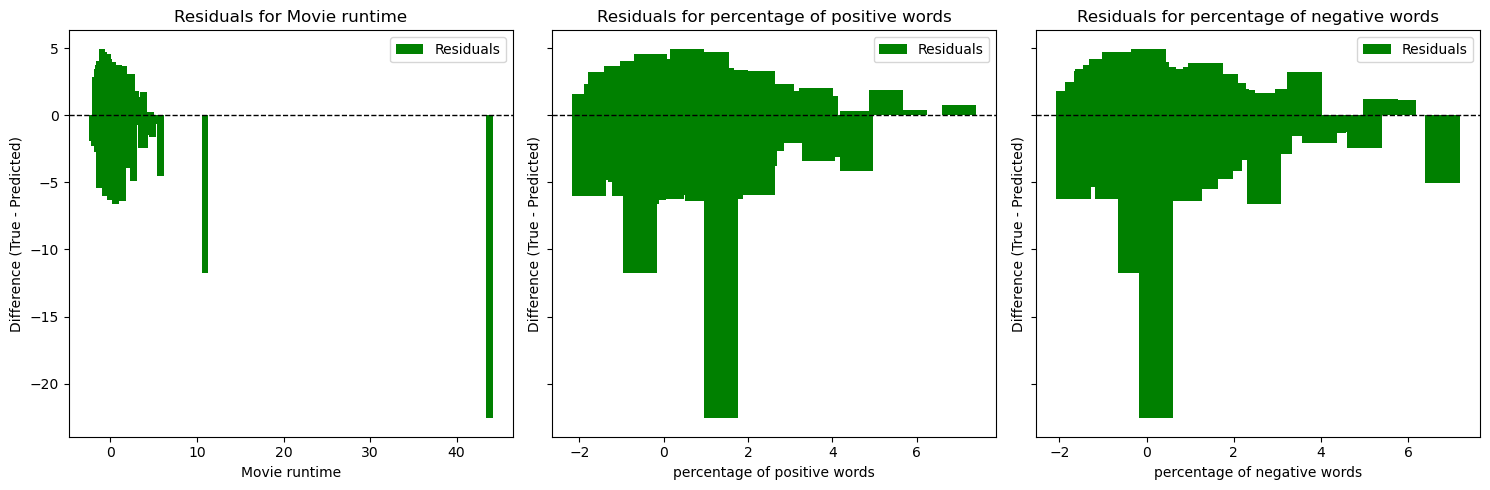

In [115]:
features_to_plot = ["Movie runtime", "percentage of positive words", "percentage of negative words"]
plot_residuals(features_to_plot, movie_summary_red_xtest__std,movie_summary_metadata_reduced_test_label, movie_summary_red_prediction)

# comment the plots

# explain why its better not to use the neg pos words perc

### Using the plot_summary dataset, we use NER, or Named Entity Recognition, to identify and classify entities (objects, people, locations, dates, etc.) in each movie summary text, extracting different entities occurences in a text and computing a "score" over these occurences on which we perform a linear regression model using other training feature which are the positive and negative words percentages and runtime, having as output the box office revenues.

In [117]:
#create a copy for the summary metadata
summary_metadata_scores = summary_metadata.copy()
print(f"The shape of the summary metadata before removing duplicates is : {summary_metadata_copy.shape}")

#Remove duplicate values
summary_metadata_scores = summary_metadata_scores.drop_duplicates("Movie Summary")
print(f"The shape of the summary metadata after removing duplicates is : {summary_metadata_copy.shape}")

The shape of the summary metadata before removing duplicates is : (42295, 2)
The shape of the summary metadata after removing duplicates is : (42295, 2)


In [141]:
#List of entity types and weights (weights are chosen manually)
entity_weights = {
    "PERSON": 1,
    "ORG": 1,
    "GPE": 1,
    "LOC": 1,
    "DATE": 0.5,
    "TIME": 0.5,
    "MONEY": 0.5,
    "PERCENT": 0.5,
    "QUANTITY": 0.5,
    "ORDINAL": 0.5,
    "CARDINAL": 0.5
}

#Function to calculate the score for a summary
def calculate_score(summary):
    doc = nlp(summary)
    
    # Calculate entity occurrences for each sentence
    sentence_scores = []
    for sentence in doc.sents:
        entity_counts = Counter([ent.label_ for ent in sentence.ents])
        sentence_score = sum(entity_counts.get(entity, 0) * weight for entity, weight in entity_weights.items())
        sentence_scores.append(sentence_score)
    #mean over scores of all sentences of each movie summary
    return np.mean(sentence_scores)

#Add a new column 'Scores' to the DataFrame
summary_metadata_scores['Score'] = summary_metadata_scores["Movie Summary"].apply(calculate_score)

#Print the resulting DataFrame
display(summary_metadata_scores)

KeyboardInterrupt: 

In [142]:
# Save scores to avoid unnecessary recomputations each time needed
summary_metadata_scores[['Movie ID','Score']].to_csv('external_dataset/movie_score.csv', index=False)

In [143]:
# Merge the movie and summary with scores dataframes based on the "Movie ID"
movie_summary_scores_metadata = pd.merge(movie_summary_metadata, summary_metadata_scores, on="Movie ID", how='outer')

# Drop NAN values
movie_summary_scores_metadata.dropna(inplace=True)

movie_summary_scores_metadata.head(3)

,Movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),year,Movie Summary_x,tokenized_summary,filtered_Tokens,percentage of positive words,percentage of negative words,percentage of neutral words,Movie Summary_y,Score
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,"Set in the second half of the 22nd century, th...","[Set, in, the, second, half, of, the, century,...","[Set, second, half, century, film, depicts, Ma...",1.515152,5.555556,92.929293,"Set in the second half of the 22nd century, th...",1.266667
1,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989.0,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,"[Finally, negotiations, are, made, for, Henry,...","[Finally, negotiations, made, Henry, named, ki...",0.000000,3.030303,96.969697,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,2.166667
2,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964.0,The film opens with Mary Poppins perched in a...,"[The, film, opens, with, Mary, Poppins, perche...","[film, opens, Mary, Poppins, perched, cloud, h...",4.509284,2.519894,92.970822,The film opens with Mary Poppins perched in a...,1.773438


In [149]:
#Dataframe containing only the used features and the output
movie_summary_scores_metadata_reduced = movie_summary_scores_metadata[['Movie runtime', 'Score', 'Movie box office revenue', "percentage of negative words", "percentage of positive words"]]

[movie_summary_scores_train, movie_summary_scores_test] = split_set(movie_summary_scores_metadata_reduced)

#X_train, y_train, X_test and y_test
movie_summary_scores_train_label=movie_summary_scores_train["Movie box office revenue"].apply(lambda x: np.log(x))
movie_summary_scores_train_features = movie_summary_scores_train.drop("Movie box office revenue", axis=1)
movie_summary_scores_test_label=movie_summary_scores_test["Movie box office revenue"].apply(lambda x: np.log(x))
movie_summary_scores_test_features = movie_summary_scores_test.drop("Movie box office revenue", axis=1)

#standerdize train and test features
movie_summary_scores_train_features_std, movie_summary_scores_test_features_std = \
    standerdize(movie_summary_scores_train_features, movie_summary_scores_test_features)

In [150]:
#train a linear regression model
model = LinearRegression()
model.fit(movie_summary_scores_train_features_std, movie_summary_scores_train_label)

#prediction on test features
movie_summary_scores_prediction = model.predict(movie_summary_scores_test_features_std)

#Evaluate the model
mse = mean_squared_error(movie_summary_scores_test_label, movie_summary_scores_prediction)
print("Mean Squared Error:", mse)

Mean Squared Error: 4.161986031872237


In [151]:
# Get the coefficients of the model
coefficients = model.coef_

# Get the intercept of the model
intercept = model.intercept_

# Print or use the coefficients and intercept as needed
print("Coefficients of the intermediate basic model:", coefficients)
print("Intercept of the intermidiate basic model:", intercept)

Coefficients of the intermediate basic model: [ 0.44763927  0.27407201 -0.06827436 -0.29627432]
Intercept of the intermidiate basic model: 16.130479764509836


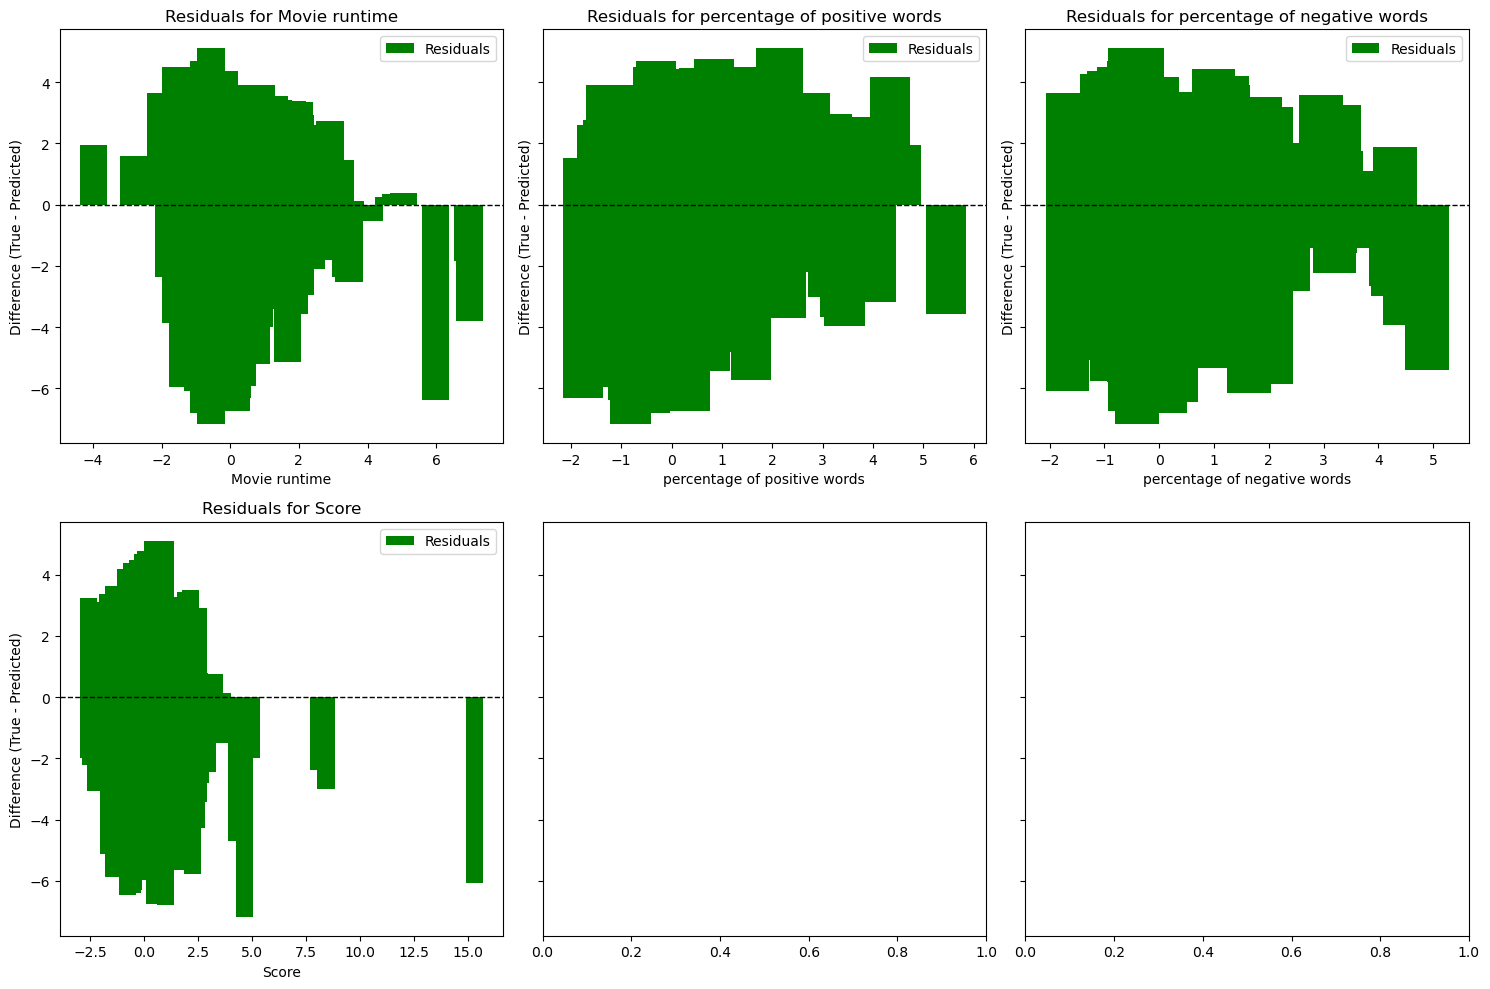

In [153]:
features_to_plot = ["Movie runtime", "percentage of positive words", "percentage of negative words", "Score"]
plot_residuals(features_to_plot, movie_summary_scores_test_features_std, movie_summary_scores_test_label, movie_summary_scores_prediction)

# add comments

### We use the new features that we obtained, percentage of positive and negative words and the scores from the plot summary, and recompute a linear regression model, as well as more features from the character and movie datasets having the box office revenue as output

In [158]:
# Merge the movie, character dataframes as well as the output of the previous part dataframe
movie_character_metadata = pd.merge(movie_metadata, character_metadata, how='outer')
movie_character_summary_metadata = pd.merge(movie_character_metadata,movie_summary_scores_metadata, how='outer')
movie_character_summary_metadata

# Drop NAN values
movie_character_summary_metadata.dropna(inplace=True)

movie_character_summary_metadata.columns#sample(3)

Index(['Movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date',
       'Movie box office revenue', 'Movie runtime',
       'Movie languages (Freebase ID:name tuples)',
       'Movie countries (Freebase ID:name tuples)',
       'Movie genres (Freebase ID:name tuples)', 'year', 'Wikipedia movie ID',
       'Character name', 'Actor date of birth', 'Actor gender',
       'Actor height (in meters)', 'Actor ethnicity (Freebase ID)',
       'Actor name', 'Actor age at movie release',
       'Freebase character/actor map ID', 'Freebase character ID',
       'Freebase actor ID', 'Movie Summary_x', 'tokenized_summary',
       'filtered_Tokens', 'percentage of positive words',
       'percentage of negative words', 'percentage of neutral words',
       'Movie Summary_y', 'Score'],
      dtype='object')

In [162]:
le = preprocessing.LabelEncoder()
       
#Encode non numerical features
le.fit(movie_character_summary_metadata['Actor gender'])
movie_character_summary_metadata['Actor gender']= le.transform(movie_character_summary_metadata['Actor gender'])
le.fit(movie_character_summary_metadata['Movie release date'])
movie_character_summary_metadata['Movie release date']= le.transform(movie_character_summary_metadata['Movie release date'])
le.fit(movie_character_summary_metadata['Movie genres (Freebase ID:name tuples)'])
movie_character_summary_metadata['Movie genres (Freebase ID:name tuples)']= le.transform(movie_character_summary_metadata['Movie genres (Freebase ID:name tuples)'])
le.fit(movie_character_summary_metadata['Movie languages (Freebase ID:name tuples)'])
movie_character_summary_metadata['Movie languages (Freebase ID:name tuples)']= le.transform(movie_character_summary_metadata['Movie languages (Freebase ID:name tuples)'])
le.fit(movie_character_summary_metadata['Character name'])
movie_character_summary_metadata['Character name']= le.transform(movie_character_summary_metadata['Character name'])
le.fit(movie_character_summary_metadata['Movie name'])
movie_character_summary_metadata['Movie name']= le.transform(movie_character_summary_metadata['Movie name'])
le.fit(movie_character_summary_metadata['Actor name'])
movie_character_summary_metadata['Actor name']= le.transform(movie_character_summary_metadata['Actor name'])
le.fit(movie_character_summary_metadata['Movie countries (Freebase ID:name tuples)'])
movie_character_summary_metadata['Movie countries (Freebase ID:name tuples)']= le.transform(movie_character_summary_metadata['Movie countries (Freebase ID:name tuples)'])

#Dataframe containing only the used features and the output
reduced_df = movie_character_summary_metadata[['Movie name', 'Movie release date', 'Movie box office revenue',
'Movie runtime', 'Movie languages (Freebase ID:name tuples)', 'Movie countries (Freebase ID:name tuples)', 
'Movie genres (Freebase ID:name tuples)', 'Character name', 'Actor gender', 'Actor name', 
'percentage of positive words', 'percentage of negative words', 'Score']]

[train, test] = split_set(reduced_df)   

#X_train, y_train, X_test and y_test
train_label=np.log(train["Movie box office revenue"])
train_features = train.drop("Movie box office revenue", axis=1)
test_label=np.log(test["Movie box office revenue"])
test_features = test.drop("Movie box office revenue", axis=1)

#standerdize train and test features
train_features_std, test_features_std = \
    standerdize(train_features, test_features)

In [163]:
#train a linear regression model
model = LinearRegression()
model.fit(train_features_std, train_label)

#prediction on test features
prediction = model.predict(test_features_std)

#Evaluate the model
mse = mean_squared_error(test_label, prediction)
print("Mean Squared Error:", mse)

Mean Squared Error: 3.907962176423259


In [164]:
# Get the coefficients of the model
coefficients = model.coef_

# Get the intercept of the model
intercept = model.intercept_

# Print or use the coefficients and intercept as needed
print("Coefficients of the intermediate basic model:", coefficients)
print("Intercept of the intermidiate basic model:", intercept)

Coefficients of the intermediate basic model: [-0.00839698  0.29077606  0.38946994  0.0521303   0.04993813 -0.09705007
  0.02381371  0.12976952 -0.01147236 -0.21214034 -0.02240299  0.34229659]
Intercept of the intermidiate basic model: 17.192713104668545


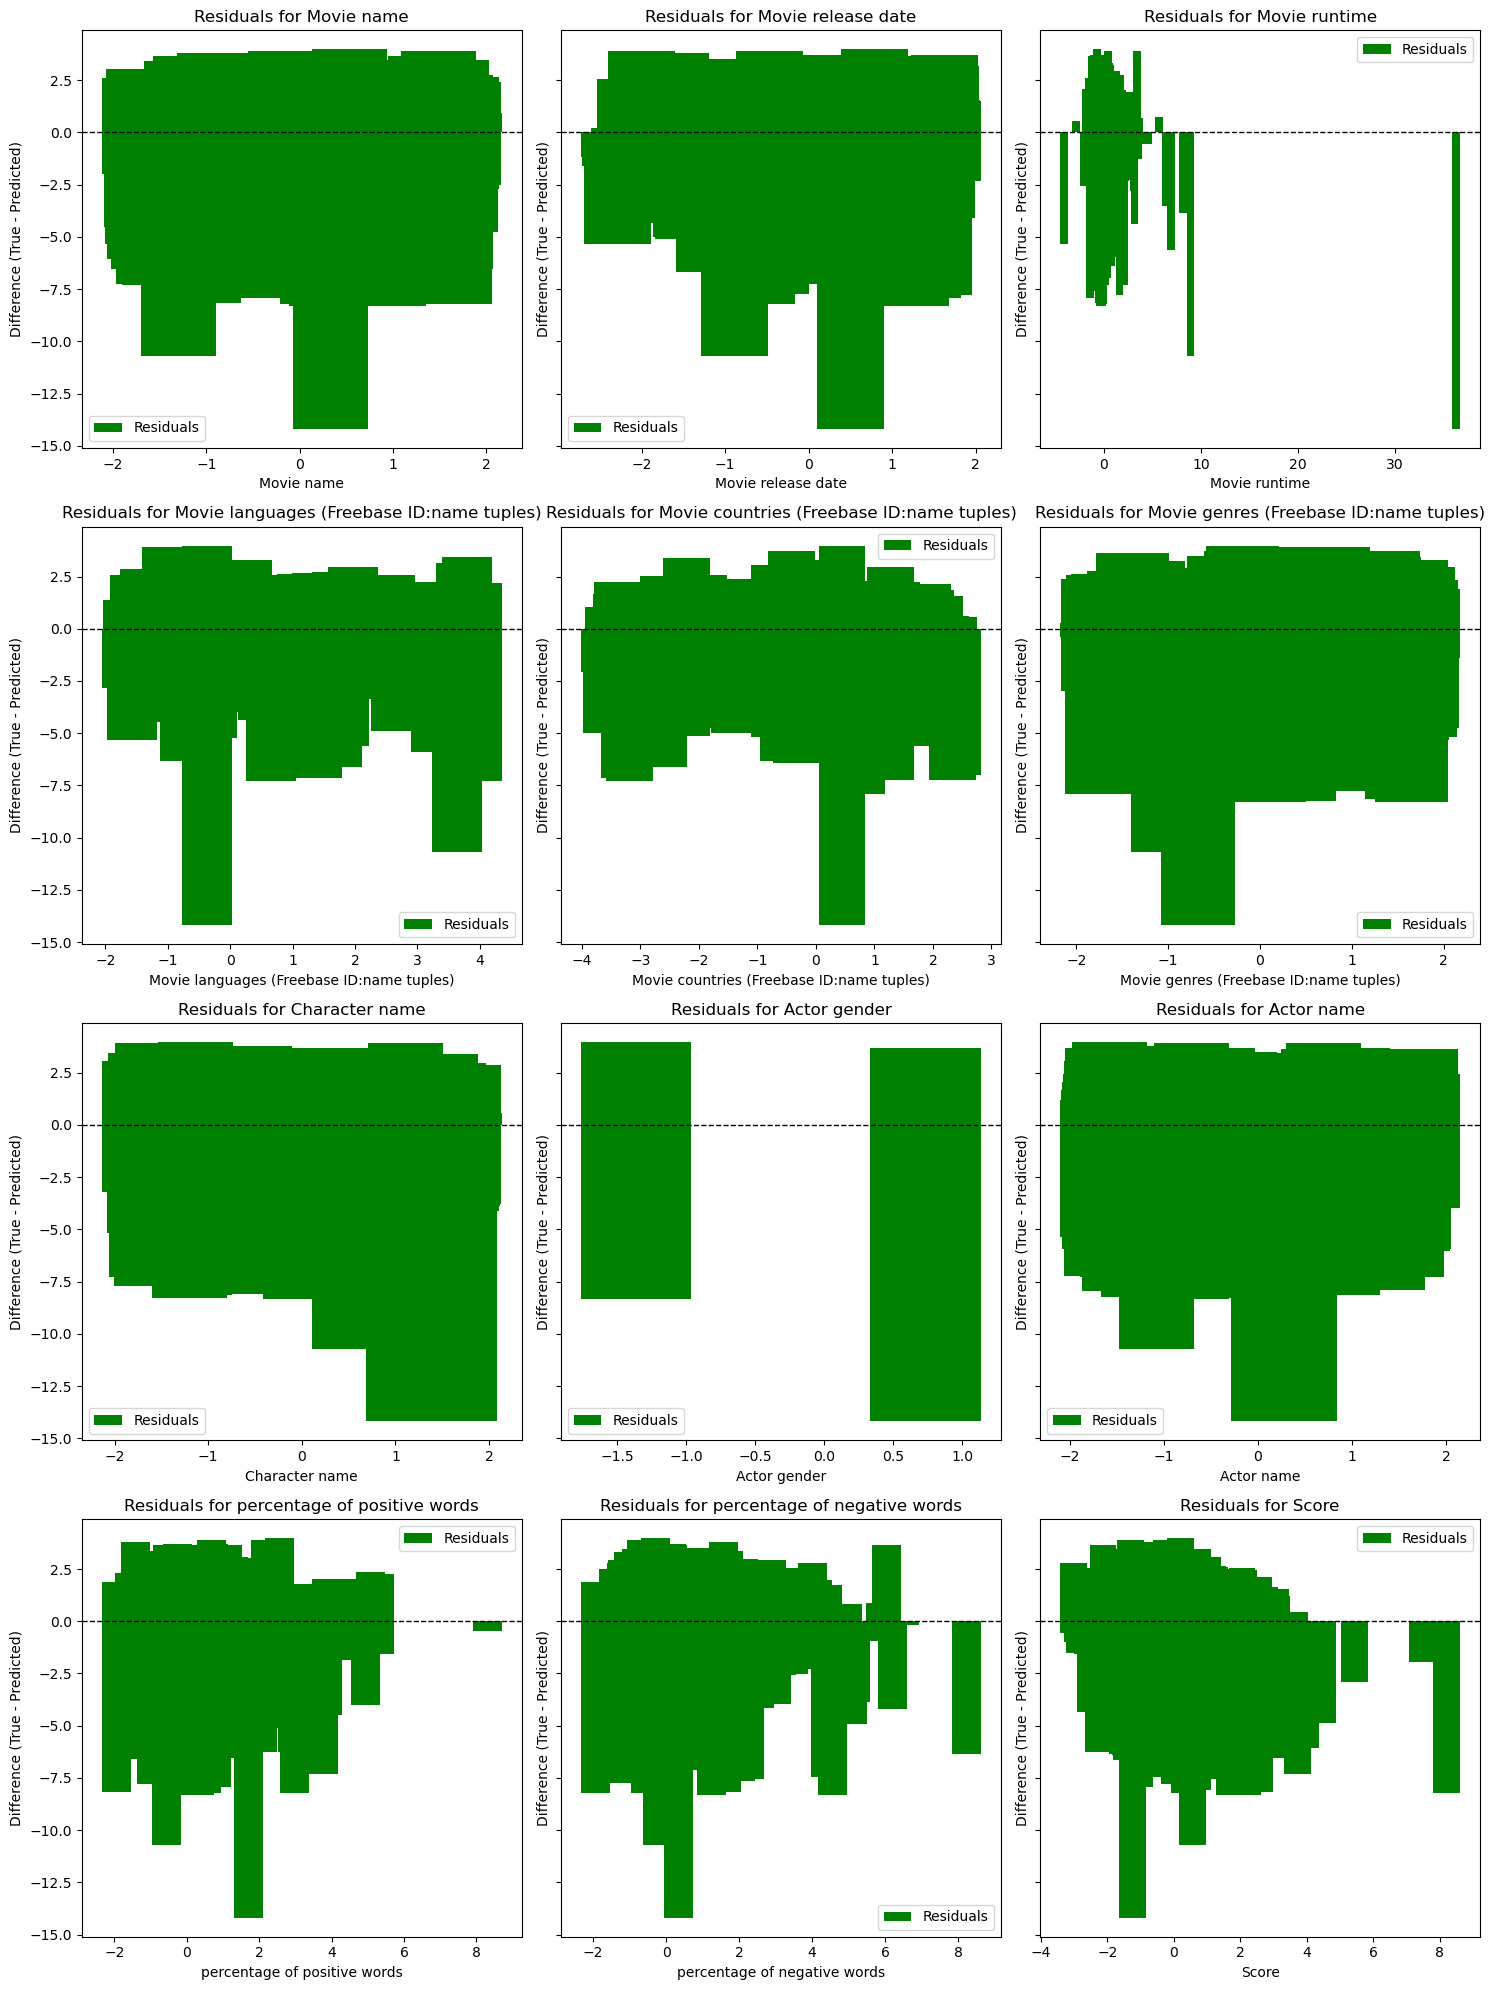

In [165]:
features_to_plot = ['Movie name', 'Movie release date', 'Movie runtime', 
'Movie languages (Freebase ID:name tuples)', 'Movie countries (Freebase ID:name tuples)', 
'Movie genres (Freebase ID:name tuples)', 'Character name', 'Actor gender', 'Actor name', 
'percentage of positive words', 'percentage of negative words', 'Score']
plot_residuals(features_to_plot, test_features_std, test_label, prediction)